In [1]:
import pandas as pd
import datetime
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
!pip install japanize_matplotlib

    tinycss2 (>=1.1.0<1.2) ; extra == 'css'
             ~~~~~~~~^


### マスタ確認とデータ整形

In [32]:
# マスタ修正の必要性を確認
rawData = 'C:\\Users\\hmill\\OneDrive\\デスクトップ\\sample_data\\データの可視化\\化療調製_AddDisデータ分析\\AddDis調製データ.csv'
mst = 'C:\\Users\\hmill\\OneDrive\\デスクトップ\\sample_data\\データの可視化\\化療調製_AddDisデータ分析\\mst_data.xlsx'
df = df = pd.read_csv(rawData, encoding='cp932')
krebs = pd.read_excel(mst, sheet_name='krebs')
krebs_cds = krebs['薬品コード'].to_list()
ex = pd.read_excel(mst, sheet_name='exclusion')
exclusion = ex['薬品コード'].to_list()
ph = pd.read_excel(mst, sheet_name='ph')
ph_dict = {}
for i in range(len(ph)):
    key = ph.iloc[i, 0]
    value = ph.iloc[i, 1]
    ph_dict[f'{key}'] = value
ph_list = ph['調製者'].to_list()

df_check = df[['薬品コード', '薬品名', '調製者']]
df_drugs = df_check.query('薬品コード not in @krebs_cds')
df_drugs = df_drugs.query('薬品コード not in @exclusion')

if len(df_drugs) == 0:
  print('薬品マスタ（krebs・除外）の修正は不要です')
else:
  df_drugs.to_excel('薬品マスタ追加リスト.xlsx', index=False)
  print('薬品マスタ（krebs・除外）への追加リストを出力しました')

df_ph = df_check.query('調製者 not in @ph_list')
if len(df_ph) == 0:
  print('薬剤師マスタの修正は不要です')
else:
  df_ph.to_excel(f'薬剤師マスタ追加リスト.xlsx', index=False)
  print('薬剤師マスタへの追加リストを出力しました')

薬品マスタ（krebs・除外）の修正は不要です
薬剤師マスタの修正は不要です


In [3]:
# str日付をdatetimeに変換
df['実施日'] = pd.to_datetime(df['実施日'])
for i in range(len(df)):
  dt = df.loc[i, '実施日']
  h1 = int(df.loc[i, '調製開始'][0:2])
  m1 = int(df.loc[i, '調製開始'][3:5])
  s1= int(df.loc[i, '調製開始'][6:8])
  df.loc[i, '調製開始'] = dt + datetime.timedelta(hours=h1, minutes=m1, seconds=s1)

  m2 = int(df.loc[i, '調製時間'][2:4])
  s2= int(df.loc[i, '調製時間'][5:7])
  df.loc[i, '調製時間'] = dt + datetime.timedelta(minutes=m2, seconds=s2)

  if type(df.loc[i, '保留時間']) == float:  #csv 空欄はfloat
    df.loc[i, '保留時間'] = dt
  else:
    m3= int(df.loc[i, '保留時間'][2:4])
    s3= int(df.loc[i, '保留時間'][5:7])
    df.loc[i, '保留時間'] = dt + datetime.timedelta(minutes=m3, seconds=s3)
    
df1 = df.query('薬品コード != @exclusion')
df1 = df1[['実施日', '入外', '科名', '病棟', 'オーダー番号', '調製者', '薬品本数', '薬品コード', '薬品名', '調製開始', '調製時間', '保留時間',]]
df1.sort_values('オーダー番号', ascending=True, inplace=True)

#オーダ番号がないレコードは削除
df1.dropna(subset='オーダー番号', inplace=True)
df1 = pd.merge(df1, krebs, how='inner')
#df1.sort_values('オーダー番号', ascending=True, inplace=True)

# オーダー番号と用量（合計）の紐づけ
df1['mg'] = df1['薬品本数'] * df1['contain']

dose = df1.pivot_table(index='オーダー番号', values='mg', aggfunc='sum')
dose.reset_index(inplace=True)

# 調製時間の算出
"""
prep_times = []
for i in range(len(df1)):
    tdelta = df1.loc[i, '調製時間'] - df1.loc[i, '保留時間']
    prep_times.append(tdelta)
df1['prep_time'] = prep_times
"""
prep_times = []
for i in range(len(df1)):
    tdelta = df1.loc[i, '調製時間'] - df1.loc[i, '保留時間']
    sec = tdelta.total_seconds()  #秒に換算
    prep_times.append(sec/60)
df1['prep_time'] = prep_times
df = df1[['実施日', '入外', '科名', '病棟', 'オーダー番号', '薬品本数', '薬品コード', '薬品名', '調製開始', 'stem', 'contain', 'prep_time', 
          '調製者'
          ]]

df.drop_duplicates(subset='オーダー番号', keep='first', inplace=True)
df = pd.merge(df, dose, how='outer')

hours = []
for i in range(len(df)):
    hour = df.loc[i, '調製開始'].strftime('%H時')
    hours.append(hour)
df['hour'] = hours

C:\Users\hmill\AppData\Local\Temp\ipykernel_1640\2849532882.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='オーダー番号', keep='first', inplace=True)


### データの可視化

#### 調製件数（1日分のデータ）

<AxesSubplot: >

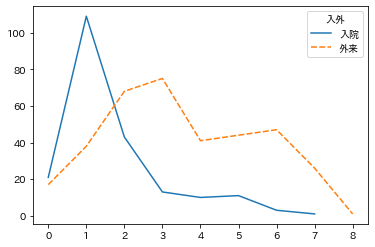

In [74]:
df2 = pd.pivot_table(df,
                     index='hour', columns='入外', values='オーダー番号',
                     aggfunc='count'
                     )
df2.reset_index(inplace=True)
#sns.set_theme(style="darkgrid")
sns.lineplot(df2)

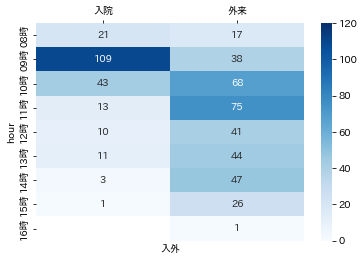

In [75]:
df2.set_index('hour', inplace=True)
plt.figure(figsize=(6, 4))
ax = sns.heatmap(df2, annot=True, fmt='g', cmap='Blues', vmax=120, vmin=0)
ax.xaxis.tick_top()

Text(0.5, 1.0, '時間ごとの化療調製Rp数')

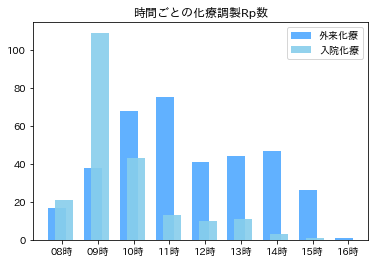

In [76]:
position = np.arange(len(df2.index))
gap = 0.2
# 2つ目の系列のポジション
#print(position+gap)
df2.reset_index(inplace=True)
plt.bar(position, df2['外来'], width=0.5, alpha=0.7, color='dodgerblue', label='外来化療')
plt.bar(position+gap, df2['入院'], width=0.5, alpha=0.9, color='skyblue', label='入院化療')
plt.xticks(position+gap*2/3, df2['hour'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=10)
plt.title('時間ごとの化療調製Rp数')

Text(0.5, 1.0, '時間ごとの化療調製Rp数')

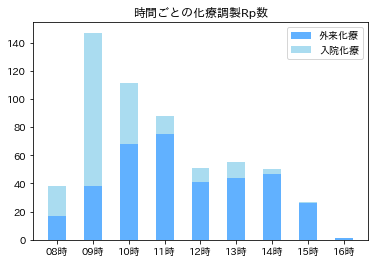

In [77]:
plt.bar(df2['hour'], df2['外来'], width=0.5, alpha=0.7, color='dodgerblue', label='外来化療')
plt.bar(df2['hour'], df2['入院'], width=0.5, alpha=0.7, color='skyblue', label='入院化療', bottom=df2['外来'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=10)
plt.title('時間ごとの化療調製Rp数')

In [78]:
#for文でスタック　※各要素の数字データ表示が上手くいかない
df2 = pd.pivot_table(dfq,
                     index='hour', columns='入外', values='オーダー番号',
                     aggfunc='count'
                     )
df2.reset_index(inplace=True)
if '外来' not in df2.columns:
    df2['外来'] = 0
fig, ax = plt.subplots()
fig1, ax1 = plt.subplots()
subcategories = ['外来', '入院']
dic_color = {'外来': 'dodgerblue', 
                '入院': 'skyblue'}
bottom = np.zeros(len(df2['hour']))
#積み上げ棒グラフ
for subcategory in subcategories:
    bars = ax.bar(df2['hour'], df2[subcategory], width=0.5, alpha=0.7, 
                    color=dic_color[subcategory], label=subcategory, bottom=bottom
                    )
    bottom += np.array(df2[subcategory])
    ax.bar_label(bars, label_type='edge')
ax.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=10)
ax.set_title(f'時間ごとの化療調製Rp数  {yyyymmdd} ({wd_dic[weekday]})')
st.pyplot(fig)

KeyError: 'オーダー番号'

In [79]:
df2.head(2)

入外,hour,入院,外来
0,08時,21.0,17.0
1,09時,109.0,38.0


In [80]:
df.columns

Index(['実施日', '入外', '科名', '病棟', 'オーダー番号', '薬品本数', '薬品コード', '薬品名', '調製開始',
       'stem', 'contain', 'prep_time', '調製者', 'mg', 'hour'],
      dtype='object')

In [81]:
df_alt = df[['実施日', '入外', 'オーダー番号', 'hour']]
df_alt_m = pd.melt(df_alt, 
                   id_vars=['実施日', 'hour', '入外'])
day = '2024-05-08'
dfq = df_alt_m.query(f'実施日 == "{day}"')
dfq.head()

,実施日,hour,入外,variable,value
3,2024-05-08,08時,外来,オーダー番号,60502631-1
5,2024-05-08,08時,外来,オーダー番号,60772944-1
7,2024-05-08,15時,外来,オーダー番号,60883448-1
15,2024-05-08,12時,入院,オーダー番号,60408790-1
16,2024-05-08,08時,外来,オーダー番号,60464828-1


In [82]:
bars = alt.Chart(dfq).mark_bar(size=25).encode(
    x=alt.X('hour', title='時間', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('count(value)', title='調製件数').stack('zero'),
    color=alt.Color('入外', scale=alt.Scale(domain=['入院', '外来'], range=['skyblue', 'dodgerblue']))
    ).properties(
                    width=400,
                    height=300,
                    title='時間ごとの調製件数（1日）'
                    )

text = alt.Chart(dfq).mark_text(dx=0, dy=-5, color='black').encode(
    x=alt.X('hour'),
    y=alt.Y('count(value)').stack('zero'),
    detail='入外',
    text=alt.Text('count(value)', format='.0f')
)

bars + text

alt.LayerChart(...)

In [9]:
#休日で外来が無い場合
day = '2024-05-06'
dfq = df.query(f'実施日 == "{day}"')
df2 = pd.pivot_table(dfq,
                    index='hour', columns='入外', values='オーダー番号',
                    aggfunc='count'
                    )
df2.reset_index(inplace=True)
df2.head()

入外,hour,入院
0,09時,11
1,10時,2


In [10]:
if '外来' not in df2.columns:
    df2['外来'] = 0

Text(0.5, 1.0, '時間ごとの化療調製Rp数(2024-05-06)')

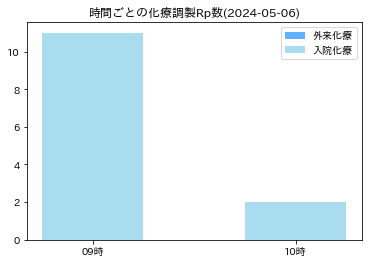

In [11]:
fig, ax = plt.subplots()
ax.bar(df2['hour'], df2['外来'], width=0.5, alpha=0.7, color='dodgerblue', label='外来化療')
ax.bar(df2['hour'], df2['入院'], width=0.5, alpha=0.7, color='skyblue', label='入院化療', bottom=df2['外来'])
ax.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=10)
ax.set_title(f'時間ごとの化療調製Rp数({day})')

#### 調製件数（複数日データ）

In [83]:
#df.columns
df3 = df.pivot_table(index=['実施日', 'hour'], columns='入外', values='オーダー番号', aggfunc='count')
df3.reset_index(inplace=True)
df3 = pd.melt(df3, id_vars=['実施日', 'hour'], value_vars=['入院', '外来'], var_name='入外', value_name='count')
df3.head()

line = alt.Chart(df3).mark_line().encode(
          x='hour',
          y='mean(count)',
          color='入外',
          tooltip=['hour', 'mean(count)']
          ).properties(
                    width=400,
                    height=300
                    )
band = alt.Chart(df3).mark_errorband(extent='ci').encode(
    x='hour',
    y=alt.Y('count', title='時間あたりの調製件数'),
    color='入外',
)
line + band

alt.LayerChart(...)

#### 医薬品ごとの調製時間

In [84]:
df4 = df.dropna(subset='stem') #マスタにない薬剤（Nan）を削除

#選択した薬剤の用量別調製時間を確認
drugs = df4['stem'].unique().tolist()
def create_jointplot(num):
  drug = drugs[num]
  df4q = df4.query('stem == @drug')
  p = sns.jointplot(x="mg", y="prep_time", data=df4q,
                  kind="reg",
                  xlim=(0, df4q['mg'].max()*1.1), ylim=(0, df4q['prep_time'].max()*1.1),
                  color="b",
                  height=5
                  )
  return drug, p

DTX


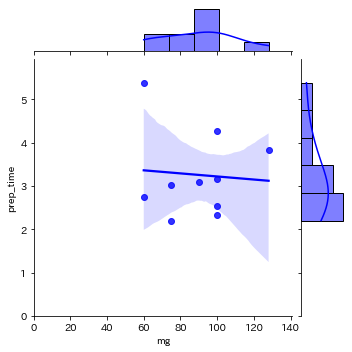

In [85]:
fig = create_jointplot(16)
print(fig[0])
print(fig[1])

<メモ>  
年次と調製時間  
ポインターを合わせればmgが分かるようにする

髄注など複数薬剤が含まれるRpはひろえない

In [86]:
df4q = df4.query('stem == "Aza"')
df4q.head()

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,stem,contain,prep_time,調製者,mg,hour
48,2024-05-07,外来,血液・腫瘍内科,NaN,60329081-1,0.67,I50814,アザシチジン注射用100,2024-05-07 08:52:06,Aza,100.0,2.750000,石崎愛弓,67.0,08時
49,2024-05-08,外来,血液・腫瘍内科,NaN,60329084-1,0.67,I50814,アザシチジン注射用100,2024-05-08 08:52:40,Aza,100.0,3.883333,渡邊晃平,67.0,08時
50,2024-05-09,外来,血液・腫瘍内科,NaN,60329089-1,0.67,I50814,アザシチジン注射用100,2024-05-09 09:08:59,Aza,100.0,1.416667,小島 礼菜,67.0,09時
51,2024-05-10,外来,血液・腫瘍内科,NaN,60329092-1,0.67,I50814,アザシチジン注射用100,2024-05-10 09:04:01,Aza,100.0,2.133333,谷 江梨奈,67.0,09時
52,2024-05-07,外来,血液・腫瘍内科,NaN,60330290-1,1.00,I50814,アザシチジン注射用100,2024-05-07 09:30:21,Aza,100.0,1.600000,鈴木 里麻,100.0,09時


In [87]:
df4q = df4q[['stem', '調製者', 'prep_time', 'mg']]  #なぜか余分な列をdropしないとエラーが出る（temestamp...）
df4q.head()

,stem,調製者,prep_time,mg
48,Aza,石崎愛弓,2.750000,67.0
49,Aza,渡邊晃平,3.883333,67.0
50,Aza,小島 礼菜,1.416667,67.0
51,Aza,谷 江梨奈,2.133333,67.0
52,Aza,鈴木 里麻,1.600000,100.0


In [88]:
base = alt.Chart(df4q)
base_bar = base.mark_bar(opacity=0.3, binSpacing=0)

xscale = alt.Scale(domain=(df4q['prep_time'].min()*0.9, df4q['prep_time'].max()*1.1))
yscale = alt.Scale(domain=(df4q['mg'].min()*0.9, df4q['mg'].max()*1.1))

points = base.mark_circle().encode(
    alt.X('prep_time', scale=xscale),
    alt.Y('mg', scale=yscale),
    )
top_hist = (base_bar.encode(
                alt.X('prep_time:Q',
                    bin=alt.Bin(maxbins=20, extent=xscale.domain),
                    stack=None,
                    title="",),
                alt.Y("count()", stack=None, title=""),
                ).properties(height=60)
            )

right_hist = (base_bar.encode(
                alt.Y('mg:Q',
                    bin=alt.Bin(maxbins=20, extent=yscale.domain),
                    stack=None,
                    title="",),
                alt.X("count()", stack=None, title=""),
                ).properties(width=60)
            )

top_hist & (points | right_hist)

alt.VConcatChart(...)

#### オーダ番号と調製者を紐づけ

In [25]:
df1.head()

,実施日,入外,科名,病棟,オーダー番号,調製者,薬品本数,薬品コード,薬品名,調製開始,調製時間,保留時間,stem,contain,mg,prep_time
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,鈴木 里麻,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:22:45,カイプロリス,40.0,40.0,4.983333
1,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,鈴木 里麻,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:22:30,カイプロリス,40.0,40.0,5.233333
2,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,鈴木 里麻,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,2024-05-07 00:27:44,2024-05-07 00:23:19,カイプロリス,40.0,40.0,4.416667
3,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,鈴木 里麻,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,2024-05-07 00:26:20,2024-05-07 00:20:37,カイプロリス,40.0,40.0,5.716667
4,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,鈴木 里麻,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,2024-05-07 00:26:20,2024-05-07 00:20:18,カイプロリス,40.0,40.0,6.033333


In [26]:
df.head()

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,stem,contain,prep_time,mg,hour
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,カイプロリス,40.0,4.983333,120.0,08時
1,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,カイプロリス,40.0,5.716667,100.0,14時
2,2024-05-07,外来,血液・腫瘍内科,NaN,60502627-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:43:15,カイプロリス,40.0,3.916667,90.0,08時
3,2024-05-08,外来,血液・腫瘍内科,NaN,60502631-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-08 08:39:08,カイプロリス,40.0,4.000000,90.0,08時
4,2024-05-10,外来,血液・腫瘍内科,NaN,60565831-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-10 14:54:58,カイプロリス,40.0,7.933333,130.0,14時


In [15]:
df1.columns

Index(['実施日', '入外', '科名', '病棟', 'オーダー番号', '調製者', '薬品本数', '薬品コード', '薬品名',
       '調製開始', '調製時間', '保留時間', 'stem', 'contain', 'mg', 'prep_time'],
      dtype='object')

In [28]:
mkr = df1[['オーダー番号', '調製者']]
mkr.drop_duplicates(keep='first', inplace=True)
df5 = pd.merge(df, mkr, how='inner')

def preptime_rank(num):
  drug = drugs[num]
  df5q = df5.query('stem == @drug')
  df5qp = df5q.pivot_table(index='調製者', values='prep_time', aggfunc=['count', 'min', 'max', 'mean'])
  df5qp.columns = ['回数', 'min', 'max', '平均']
  df5qp.sort_values('平均', ascending=True, inplace=True)
  return drug, df5qp.round(2)

for i in range(len(drugs)):
  rank = preptime_rank(i)
  print('------------------------------------------------------')
  print(f'【{rank[0]}】')
  print(rank[1])
  print()

C:\Users\hmill\AppData\Local\Temp\ipykernel_10756\306818771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mkr.drop_duplicates(keep='first', inplace=True)


------------------------------------------------------
【カイプロリス】
        回数   min   max    平均
調製者                         
森﨑 萌     1  4.00  4.00  4.00
鈴木 里麻    4  3.92  7.00  5.40
本山 大夢    1  6.30  6.30  6.30
小島 礼菜    2  5.47  8.22  6.84
池田 のどか   2  7.12  9.05  8.08
山下拓海     3  7.75  8.60  8.09

------------------------------------------------------
【ダラキュ―ロ】
        回数   min   max    平均
調製者                         
渡邊晃平     1  1.68  1.68  1.68
森﨑 萌     3  1.68  2.03  1.86
鈴木 里麻    6  1.65  2.08  1.86
阿部 彩香    1  2.07  2.07  2.07
山下拓海     3  2.00  2.63  2.27
小島 礼菜    2  2.45  2.45  2.45
池田 のどか   2  2.93  3.12  3.02

------------------------------------------------------
【EPI】
       回数   min   max    平均
調製者                        
谷 江梨奈   1  2.85  2.85  2.85
山下拓海    1  8.43  8.43  8.43

------------------------------------------------------
【CPA】
       回数   min    max    平均
調製者                         
森 彩乃    1  2.37   2.37  2.37
本山 大夢   1  3.12   3.12  3.12
森﨑 萌    2  3.90   6.53  5.

#### 医薬品ごと（全体）

In [33]:
df5.head()

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,stem,contain,prep_time,mg,hour,調製者
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,カイプロリス,40.0,4.983333,120.0,08時,鈴木 里麻
1,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,カイプロリス,40.0,5.716667,100.0,14時,鈴木 里麻
2,2024-05-07,外来,血液・腫瘍内科,NaN,60502627-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:43:15,カイプロリス,40.0,3.916667,90.0,08時,鈴木 里麻
3,2024-05-08,外来,血液・腫瘍内科,NaN,60502631-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-08 08:39:08,カイプロリス,40.0,4.000000,90.0,08時,森﨑 萌
4,2024-05-10,外来,血液・腫瘍内科,NaN,60565831-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-10 14:54:58,カイプロリス,40.0,7.933333,130.0,14時,山下拓海


In [34]:
df5p = df5.pivot_table(index='stem', values='prep_time', aggfunc=['count', 'min', 'max', 'mean'])
df5p.columns = ['回数', 'min', 'max', '平均']
df5p.sort_values('平均', ascending=True, inplace=True)
df5p

,回数,min,max,平均
stem,,,,
エプキンリ,2,0.516667,1.300000,0.908333
ジフォルタ,1,1.683333,1.683333,1.683333
パージェタ,2,1.650000,1.900000,1.775000
ロイナーゼ,1,1.783333,1.783333,1.783333
テセントリク,6,1.400000,2.150000,1.786111
...,...,...,...,...
ジェブタナ,1,8.200000,8.200000,8.200000
ダカルバジン,2,7.933333,8.733333,8.333333
MTX,16,1.883333,46.116667,9.537500
